In [8]:
from __future__ import print_function

In [9]:
import matplotlib as mpl
# set this 'backend' when using jupyter; do this before importing pyplot
mpl.use('nbagg')
import matplotlib.pyplot as plt

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import numpy as np
import scipy as sp
from scipy import stats
from sklearn import datasets as skdatasets
from sklearn.utils import shuffle as shuffle_in_unison


import sys
sys.path.append('/home/felix/Research/Adversarial Research/FGN---Research/')
import Finite_Gaussian_Network_lib as fgnl
import Finite_Gaussian_Network_lib.fgn_helper_lib as fgnh

In [13]:
!gpustat

countdown  Mon Sep  9 13:19:31 2019
[0] GeForce GTX 1080 | 54'C,   0 % |  6979 /  8119 MB | felix(669M) soumi(2157M) soumi(2157M) soumi(917M) soumi(1067M)
[1] GeForce GTX 1080 | 64'C,  72 % |  7153 /  8118 MB | soumi(3909M) soumi(847M) soumi(843M) vietanh(681M)


In [12]:
# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
use_cuda = True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")
print("Using device:", device)

# manualy set cuda device
torch.cuda.set_device(0)

CUDA Available:  True
Using device: cuda


In [14]:
# # random seeds
# torch.manual_seed(999)
# np.random.seed(999)

# torch.backends.cudnn.deterministic = True
# torch.cuda.manual_seed_all(999)

In [15]:
# load MNIST data
batch_size = 192
(mnist_train_loader, mnist_val_loader, mnist_test_loader) = fgnh.mnist_dataloaders(batch_size)
# minimum/maximum pixel value post normalization, from train dataset
min_pix = -0.4242129623889923095703125
max_pix =  2.8214867115020751953125000
# mean and std of train set
train_mean = -0.0000061691193877777550369501113891601562500000000
train_std = 0.999999344348907470703125000000

Shape: torch.Size([50000, 28, 28])
type: <type 'numpy.ndarray'>
shape: torch.Size([28, 28])
Label: 5
type: <class 'torch.Tensor'>


<IPython.core.display.Javascript object>


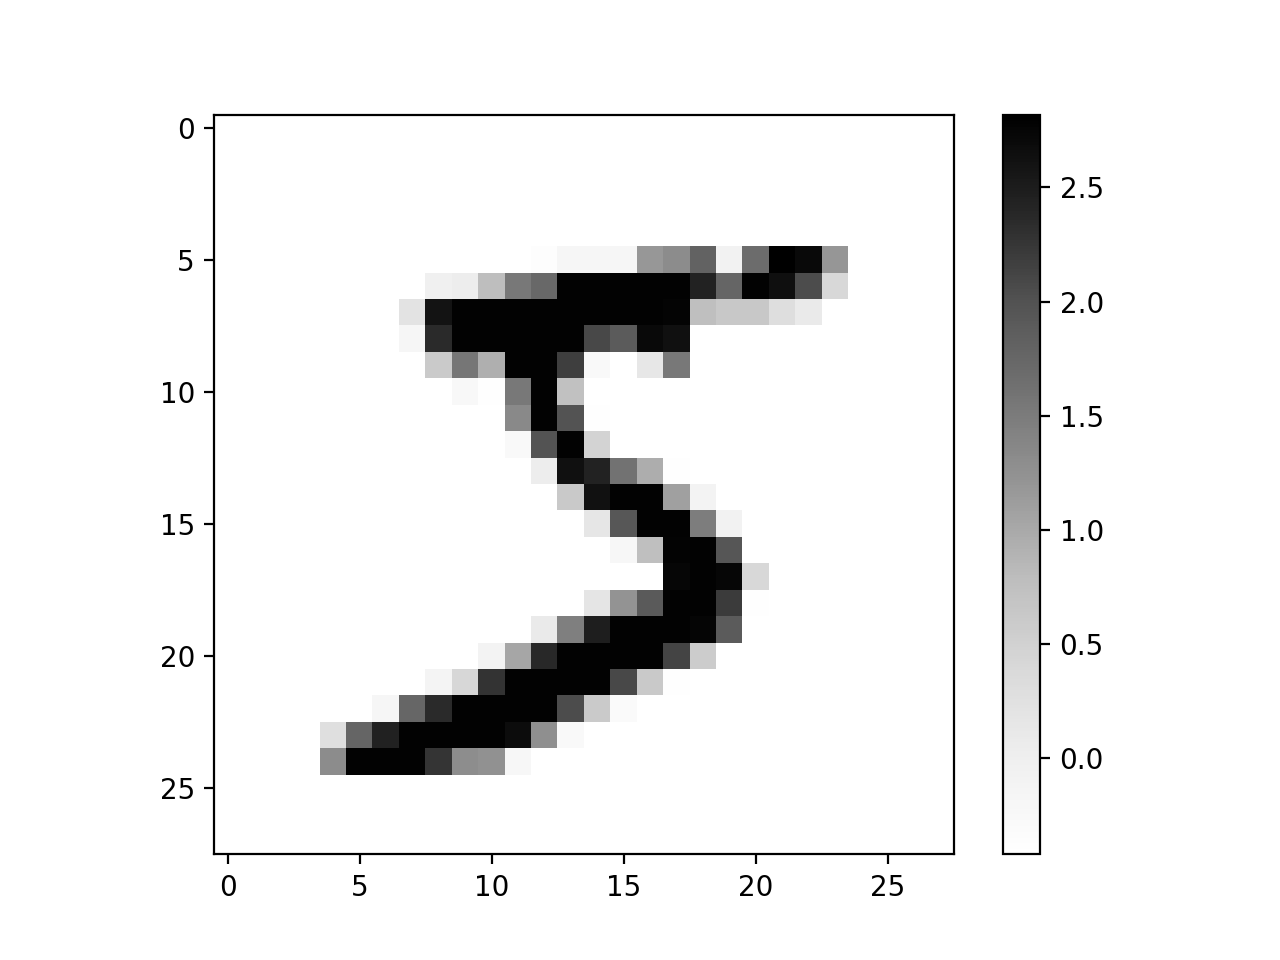

In [16]:
# show an example
print("Shape:", mnist_train_loader.dataset.tensors[0].shape)
x = mnist_train_loader.dataset.tensors[0][0]
print("type:", type(x.numpy()))
print("shape:", x.shape)
# print("sample:", x.numpy())

y =mnist_train_loader.dataset.tensors[1][0]
print("Label:",y.numpy())
print("type:", type(y))

plt.imshow(x, cmap=plt.cm.get_cmap('Greys'))
plt.colorbar()
plt.show()

In [17]:
# PART 1: define and train a network 
#  with WandB

In [23]:
import wandb
wandb.init()

W&B Run: https://app.wandb.ai/grezesf/FGN---Research-dev/runs/7831jn8y

In [19]:
### Loss Functions for the FGN
# importances of the constraints
lmbda_l2 = (4.0*0.1/len(mnist_train_loader.dataset))
lmbda_sigs = 10.0*lmbda_l2
# sig_params = sum(p.numel() for n,p in fgn_model.named_parameters() if 'sigs' in n)
# lmbda_sigs = (1.0/sig_params)

# lmbda_l2 = 0.0
# lmbda_sigs = 0.0
print("lambda for l2 loss", lmbda_l2)
print("lambda for sigs^2 loss", lmbda_sigs)

cross_ent_loss = fgnl.def_fgn_cross_ent_loss(lmbda_l2, lmbda_sigs)

lambda for l2 loss 8e-06
lambda for sigs^2 loss 8e-05


In [20]:
# shared network parameters
hidden_l_nums = [32,32]
drop_p = 1.0/32.0

In [ ]:
# # classic model init
# model = fgnl.Feedforward_Classic_net(in_feats=28*28, out_feats=10, hidden_l_nums=hidden_l_nums, drop_p=drop_p).to(device)

print("hidden layers:", hidden_l_nums)
print("drop prob:", drop_p)
# fgn specific params
covar_type = 'diag'
print("covariance:", covar_type)
ordinal = float(2)
print("ordinal: {0:.10f}".format(ordinal))
non_lin = False
print("non linearity", non_lin)
noisy_centers = False
print("noisy centers:", noisy_centers)
random_eval = False
print("Random Eval", random_eval)

In [21]:
#fgn model init
model = fgnl.Feedforward_FGN_net(in_feats=28*28, out_feats=10, hidden_l_nums=hidden_l_nums, drop_p=drop_p,
                                     covar_type=covar_type, ordinal=ordinal, non_lin=non_lin, 
                                     noisy_centers=noisy_centers).to(device)

hidden layers: [32, 32]
drop prob: 0.03125
covariance: diag
ordinal: 2.0000000000
non linearity False
noisy centers: False
Random Eval False


In [22]:
wandb.watch(model)

In [24]:
# define model params to optimize
optimizer = optim.RMSprop(filter(lambda p: p.requires_grad, model.parameters()),momentum=0.5)

In [25]:
epochs = 5

In [26]:
# train the network for N epochs
train_res = fgnh.train(model, mnist_train_loader, 
                             cross_ent_loss, optimizer, epochs, save_hist=2, verbose=True, 
                             pred_func=fgnh.cross_ent_pred_accuracy, test_loader=mnist_val_loader)

Epoch 0 Train set - Average loss: 0.9494, Accuracy: 36922/50000 (74%)
Test set - Average loss: 0.7370, Accuracy: 7739/10000 (77%)
Epoch 1 Train set - Average loss: 0.3893, Accuracy: 44676/50000 (89%)
Test set - Average loss: 0.6246, Accuracy: 8233/10000 (82%)
Epoch 2 Train set - Average loss: 0.3541, Accuracy: 45117/50000 (90%)
Test set - Average loss: 0.8578, Accuracy: 7225/10000 (72%)
Epoch 3 Train set - Average loss: 0.3435, Accuracy: 45248/50000 (90%)
Test set - Average loss: 1.2506, Accuracy: 6908/10000 (69%)
Epoch 4 Train set - Average loss: 0.3233, Accuracy: 45452/50000 (91%)
Test set - Average loss: 0.5249, Accuracy: 8477/10000 (85%)
